In [2]:
import duckdb
from pathlib import Path

db_path = Path("..") / "data" / "analytics.duckdb"
con = duckdb.connect(str(db_path))

con.execute("SELECT 'Connected to DuckDB'").fetchall()

[('Connected to DuckDB',)]

In [ ]:
con.execute("SHOW TABLES").df()

,name
0,dim_league
1,dim_player
2,dim_team
3,dim_venue
4,fact_match
5,fact_player_season
6,fact_team_season


: 

In [3]:
query = """
SELECT 
    m.season_year,
    m.league_id,
    l.league_name,
    COUNT(*) AS total_matches
FROM fact_match m
LEFT JOIN dim_league l 
    ON m.league_id = l.league_id
GROUP BY m.season_year, m.league_id, l.league_name
ORDER BY m.season_year, l.league_name;
"""

df = con.execute(query).df()
df

,season_year,league_id,league_name,total_matches
0,2022,140,La Liga,380
1,2022,71,Serie A,380
2,2022,2,UEFA Champions League,214
3,2023,140,La Liga,380
4,2023,71,Serie A,380
5,2023,2,UEFA Champions League,214
6,2024,140,La Liga,380
7,2024,71,Serie A,380
8,2024,2,UEFA Champions League,279


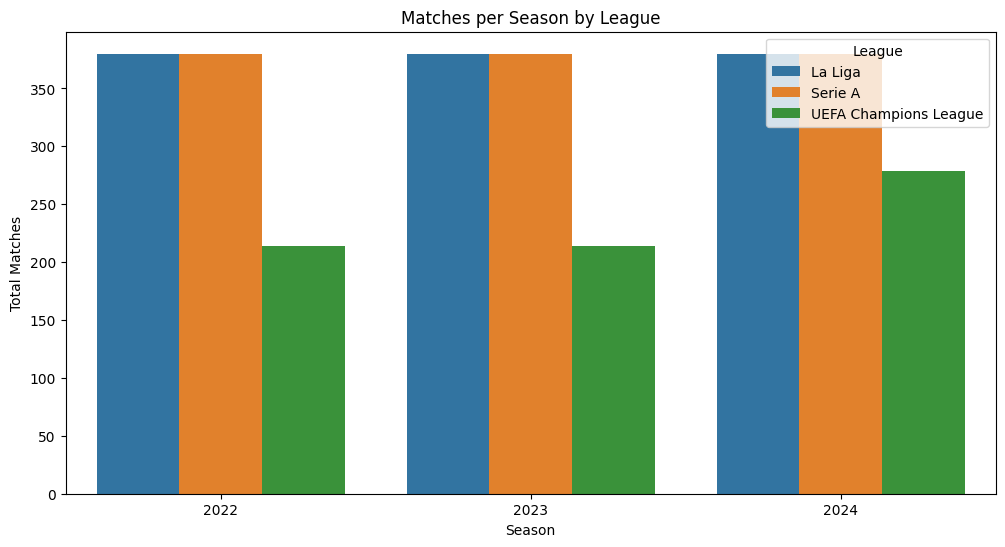

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.barplot(
    data=df,
    x="season_year",
    y="total_matches",
    hue="league_name"
)

plt.title("Matches per Season by League")
plt.xlabel("Season")
plt.ylabel("Total Matches")
plt.legend(title="League")
plt.show()

In [5]:
query_goals = """
SELECT
    m.season_year,
    l.league_name,
    SUM(m.goals_home + m.goals_away) AS total_goals,
    AVG(m.goals_home + m.goals_away) AS avg_goals_per_match
FROM fact_match m
LEFT JOIN dim_league l 
    ON m.league_id = l.league_id
GROUP BY m.season_year, l.league_name
ORDER BY m.season_year, l.league_name;
"""

goals_df = con.execute(query_goals).df()
goals_df

,season_year,league_name,total_goals,avg_goals_per_match
0,2022,La Liga,955.0,2.513158
1,2022,Serie A,905.0,2.381579
2,2022,UEFA Champions League,614.0,2.869159
3,2023,La Liga,1005.0,2.644737
4,2023,Serie A,946.0,2.489474
5,2023,UEFA Champions League,640.0,2.990654
6,2024,La Liga,995.0,2.618421
7,2024,Serie A,929.0,2.444737
8,2024,UEFA Champions League,885.0,3.172043


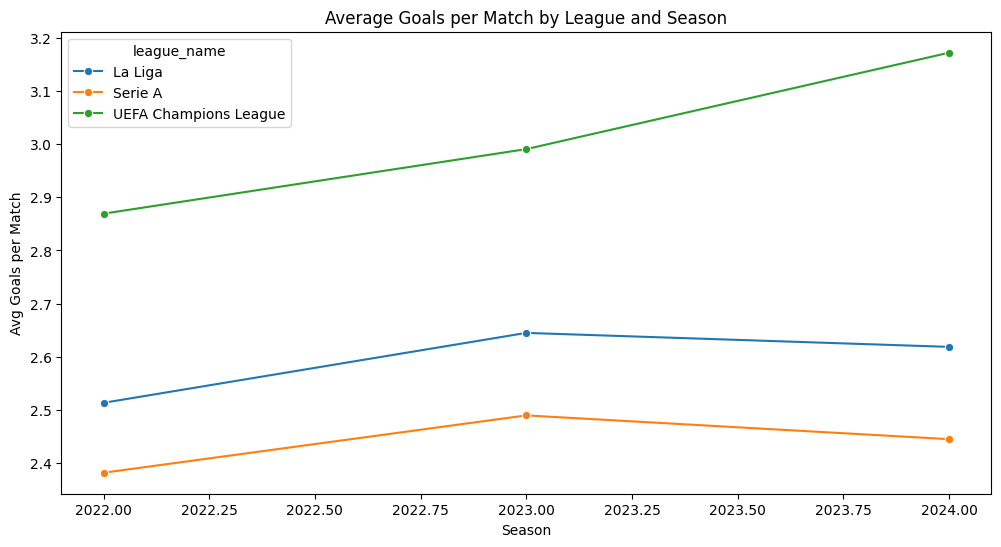

In [6]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=goals_df,
    x="season_year",
    y="avg_goals_per_match",
    hue="league_name",
    marker="o"
)

plt.title("Average Goals per Match by League and Season")
plt.xlabel("Season")
plt.ylabel("Avg Goals per Match")
plt.show()

In [7]:
query_goals = """
SELECT
    m.season_year,
    l.league_name,
    SUM(m.goals_home) AS total_goals_home,
    SUM(m.goals_away) AS total_goals_away,
    SUM(m.goals_home + m.goals_away) AS total_goals,
    AVG(m.goals_home) AS avg_goals_home_per_match,
    AVG(m.goals_away) AS avg_goals_away_per_match,
    AVG(m.goals_home + m.goals_away) AS avg_goals_per_match
FROM fact_match m
LEFT JOIN dim_league l 
    ON m.league_id = l.league_id
GROUP BY m.season_year, l.league_name
ORDER BY m.season_year, l.league_name;
"""

goals_df = con.execute(query_goals).df()
goals_df

,season_year,league_name,total_goals_home,total_goals_away,total_goals,avg_goals_home_per_match,avg_goals_away_per_match,avg_goals_per_match
0,2022,La Liga,553.0,402.0,955.0,1.455263,1.057895,2.513158
1,2022,Serie A,534.0,371.0,905.0,1.405263,0.976316,2.381579
2,2022,UEFA Champions League,352.0,262.0,614.0,1.644860,1.224299,2.869159
3,2023,La Liga,564.0,441.0,1005.0,1.484211,1.160526,2.644737
4,2023,Serie A,539.0,407.0,946.0,1.418421,1.071053,2.489474
5,2023,UEFA Champions League,352.0,288.0,640.0,1.644860,1.345794,2.990654
6,2024,La Liga,552.0,443.0,995.0,1.452632,1.165789,2.618421
7,2024,Serie A,536.0,393.0,929.0,1.410526,1.034211,2.444737
8,2024,UEFA Champions League,498.0,387.0,885.0,1.784946,1.387097,3.172043


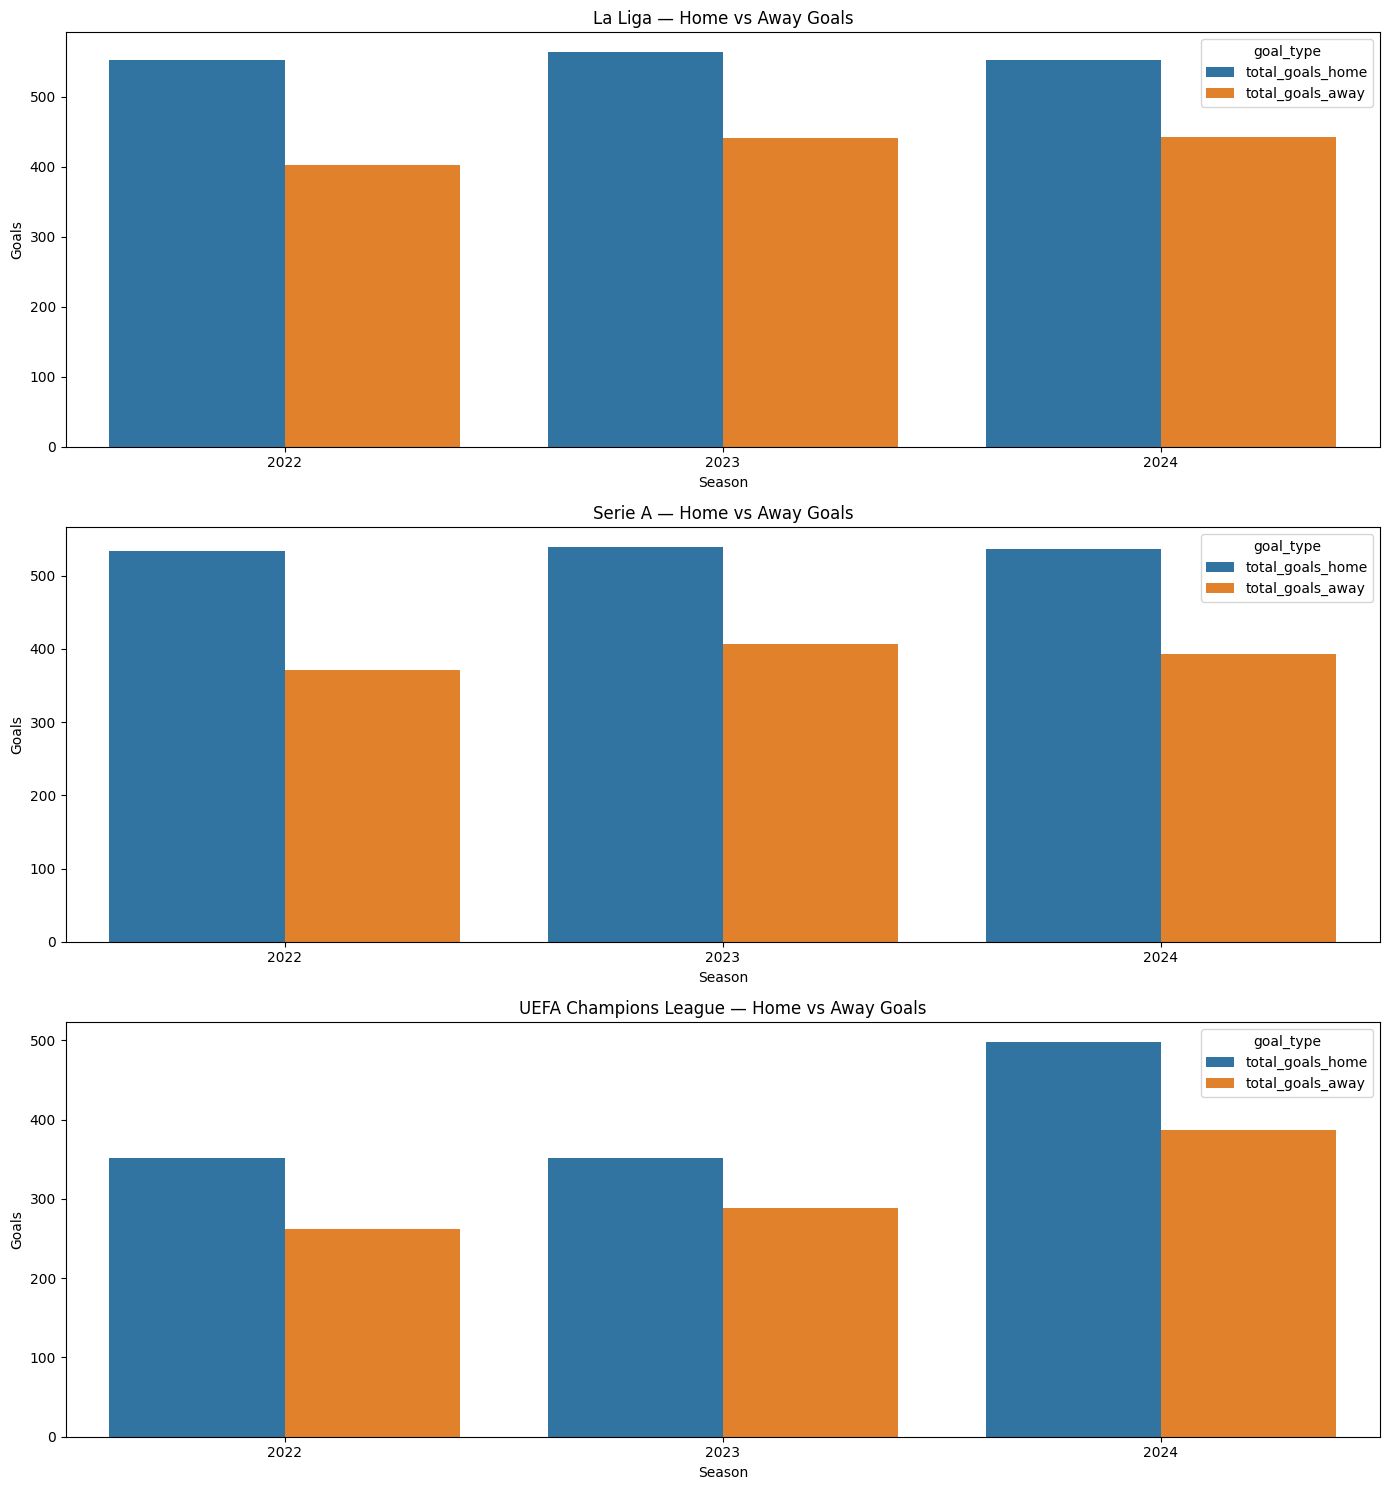

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

leagues = goals_df["league_name"].unique()
num_leagues = len(leagues)

fig, axes = plt.subplots(num_leagues, 1, figsize=(14, 5 * num_leagues))

for ax, league in zip(axes, leagues):
    df_league = goals_df[goals_df["league_name"] == league]

    sns.barplot(
        data=df_league.melt(
            id_vars=["season_year"],
            value_vars=["total_goals_home", "total_goals_away"],
            var_name="goal_type",
            value_name="goals"
        ),
        x="season_year",
        y="goals",
        hue="goal_type",
        ax=ax
    )

    ax.set_title(f"{league} — Home vs Away Goals")
    ax.set_xlabel("Season")
    ax.set_ylabel("Goals")

plt.tight_layout()
plt.show()

In [9]:
query_hai = """
SELECT
    m.season_year,
    l.league_name,

    -- Averages
    AVG(m.goals_home) AS avg_goals_home,
    AVG(m.goals_away) AS avg_goals_away,

    -- Home Advantage Index
    CASE 
        WHEN AVG(m.goals_away) = 0 THEN NULL
        ELSE AVG(m.goals_home) / AVG(m.goals_away)
    END AS home_advantage_index

FROM fact_match m
LEFT JOIN dim_league l
    ON m.league_id = l.league_id

GROUP BY m.season_year, l.league_name
ORDER BY m.season_year, l.league_name;
"""

hai_df = con.execute(query_hai).df()
hai_df

,season_year,league_name,avg_goals_home,avg_goals_away,home_advantage_index
0,2022,La Liga,1.455263,1.057895,1.375622
1,2022,Serie A,1.405263,0.976316,1.439353
2,2022,UEFA Champions League,1.644860,1.224299,1.343511
3,2023,La Liga,1.484211,1.160526,1.278912
4,2023,Serie A,1.418421,1.071053,1.324324
5,2023,UEFA Champions League,1.644860,1.345794,1.222222
6,2024,La Liga,1.452632,1.165789,1.246050
7,2024,Serie A,1.410526,1.034211,1.363868
8,2024,UEFA Champions League,1.784946,1.387097,1.286822


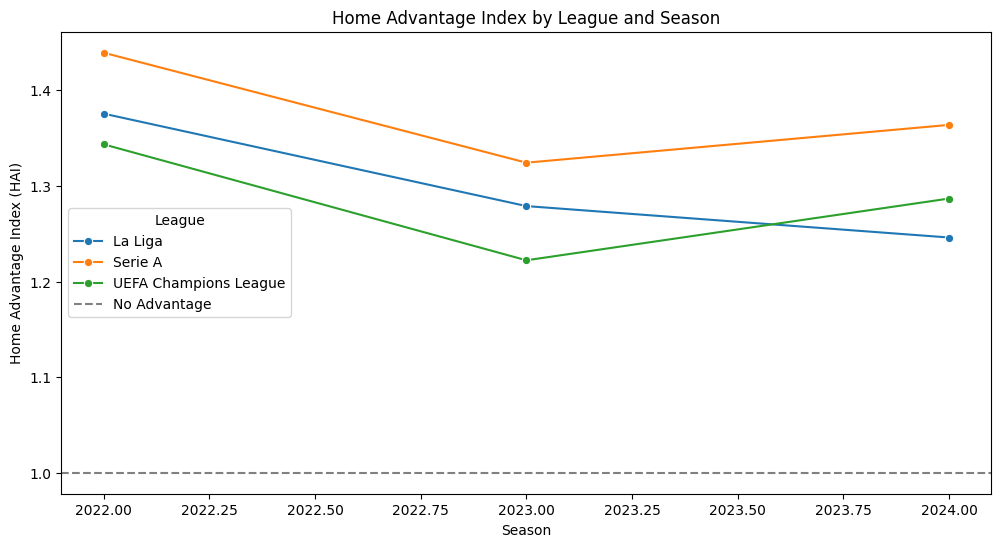

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=hai_df,
    x="season_year",
    y="home_advantage_index",
    hue="league_name",
    marker="o"
)

plt.title("Home Advantage Index by League and Season")
plt.xlabel("Season")
plt.ylabel("Home Advantage Index (HAI)")
plt.axhline(1.0, color="gray", linestyle="--", label="No Advantage")
plt.legend(title="League")
plt.show()